In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Load the data
train_path = 'train_smote.csv'
test_path = 'test.csv'
val_path = 'val.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
val = pd.read_csv(val_path)
# Display the first few rows of the dataframe to understand its structure
train.head()

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
0,99,1.617184,-0.146800,-0.321927,0.409636,-0.405516,0.590972,-0.238964,-0.248308,-0.108401,-0.947607,-0.524219,-1.177506,1,1,1,1,1,1,1
1,155,0.588185,-0.611734,-0.587234,-0.676818,-0.405516,-0.477086,-0.169707,0.545741,-0.723014,0.518002,0.473076,1.104369,1,0,1,0,0,2,1
2,116,1.185611,1.046118,-0.056619,0.400582,0.262393,-0.277559,-0.184681,-0.275689,4.161549,1.857083,-0.823408,-0.036569,0,0,1,1,0,2,1
3,271,-0.389987,0.042906,-0.498798,-0.219602,-0.047708,-0.042821,-0.480897,-0.204145,0.845868,0.286035,-1.022867,-0.036569,1,0,1,0,1,1,1
4,184,-0.920536,-1.174891,1.712099,1.378390,0.071562,3.055723,0.200914,0.792171,0.247429,2.205033,-0.923137,-0.036569,1,0,1,0,1,1,0


In [3]:
# Separate the features and the target variable
X_train = train.drop(['ID', 'Status'], axis=1)
y_train = train['Status']
X_test = test.drop(['ID', 'Status'], axis=1)
y_test = test['Status']
X_val = val.drop(['ID', 'Status'], axis=1)
y_val = val['Status']
X_train_val = pd.concat([X_train, X_val], ignore_index=True)
y_train_val = pd.concat([y_train, y_val], ignore_index=True)

# Check the size of each set to confirm the split ratio
len(X_train), len(X_val), len(X_train_val), len(X_test)

(357, 47, 404, 47)

In [4]:
init_options = ['k-means++', 'random']
n_init_options = [1, 2, 3, 5, 10, 15]

best_score = -1
best_params = {}

for init in init_options:
    for n_init in n_init_options:
        # Train model
        kmeans = KMeans(n_clusters=3, init=init, n_init=n_init, random_state=42)
        kmeans.fit(X_train)
        
        # Evaluate on validation set
        preds = kmeans.predict(X_val)
        score = silhouette_score(X_val, preds)
        
        # get best score and parameters
        if score > best_score:
            best_score = score
            best_params = {'init': init, 'n_init': n_init}

print("Best paras: ", best_params)
print("Highest Silhouette Score: ", best_score)

Best paras:  {'init': 'k-means++', 'n_init': 5}
Highest Silhouette Score:  0.1972548595542185


In [5]:
kmeans_best = KMeans(n_clusters=3, init=best_params['init'], n_init=best_params['n_init'], random_state=42)
kmeans_best.fit(X_train_val)

test_clusters = kmeans_best.predict(X_test)

cluster_to_label_mapping = {}
for cluster_id in range(3):
    # Most frequent
    labels_in_cluster = y_train_val[kmeans_best.labels_ == cluster_id]
    most_common_label = labels_in_cluster.mode()[0]
    cluster_to_label_mapping[cluster_id] = most_common_label
    
predicted_labels_test = [cluster_to_label_mapping[cluster] for cluster in test_clusters]
accuracy = accuracy_score(y_test, predicted_labels_test)
print("Accuracy on test set: ", accuracy)

Accuracy on test set:  0.6808510638297872


In [6]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

init_options = ['k-means++', 'random']
n_init_options = [1, 2, 3, 5, 10, 15]
best_score = -1
best_params = {}

for init in init_options:
    for n_init in n_init_options:
        kmeans = KMeans(n_clusters=3, init=init, n_init=n_init, random_state=42)
        kmeans.fit(X_train_pca)
        
        preds = kmeans.predict(X_val_pca)
        score = silhouette_score(X_val_pca, preds)
        
        if score > best_score:
            best_score = score
            best_params = {'init': init, 'n_init': n_init}

print("Best parameters: ", best_params)
print("Highest Silhouette Score: ", best_score)

Best parameters:  {'init': 'k-means++', 'n_init': 1}
Highest Silhouette Score:  0.4208521835230009


In [7]:
X_train_val_pca = pca.transform(X_train_val)
X_test_pca = pca.transform(X_test)

kmeans_best = KMeans(n_clusters=3, init=best_params['init'], n_init=best_params['n_init'], random_state=42)
kmeans_best.fit(X_train_val_pca)

test_clusters = kmeans_best.predict(X_test_pca)

cluster_to_label_mapping = {}
for cluster_id in range(3):
    # Most frequent
    labels_in_cluster = y_train_val[kmeans_best.labels_ == cluster_id]
    most_common_label = labels_in_cluster.mode()[0]
    cluster_to_label_mapping[cluster_id] = most_common_label
    
predicted_labels_test = [cluster_to_label_mapping[cluster] for cluster in test_clusters]
accuracy = accuracy_score(y_test, predicted_labels_test)
print("Accuracy on test set: ", accuracy)

Accuracy on test set:  0.7446808510638298


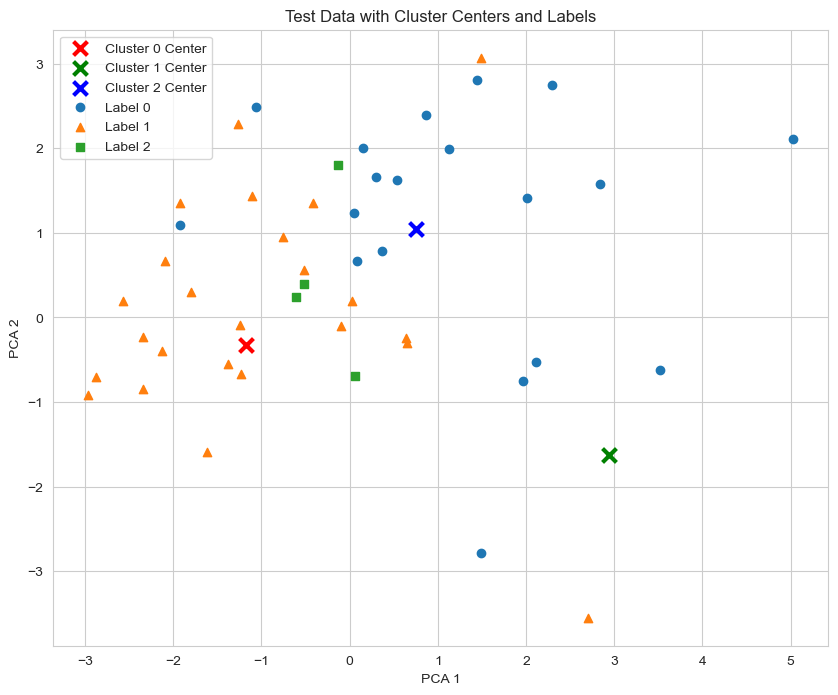

In [8]:
# Define a color for each cluster
cluster_colors = ['red', 'green', 'blue']
# Define a marker for each true label
label_markers = {0: 'o', 1: '^', 2: 's'}

plt.figure(figsize=(10, 8))

# Plot the cluster centers
centers = kmeans_best.cluster_centers_
for i, center in enumerate(centers):
    plt.scatter(center[0], center[1], c=cluster_colors[i], marker='x', s=100, linewidths=3, label=f'Cluster {i} Center')

# Plot the test data points
for label, marker in label_markers.items():
    # Select data points with the current label
    ix = y_test == label
    
    # Plot all test points with the current label
    plt.scatter(X_test_pca[ix, 0], X_test_pca[ix, 1], marker=marker, label=f"Label {label}")

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.title('Test Data with Cluster Centers and Labels')
plt.show()